In [20]:
import h5py
import numpy as np

data_s = h5py.File('../data/julius_dev/scores_comet_skintle-S.h5', 'r')["scores"]
data_m = h5py.File('../data/julius_dev/scores_comet_skintle-M.h5', 'r')["scores"]
data_l = h5py.File('../data/julius_dev/scores_comet_skintle-L.h5', 'r')["scores"]
data_k = h5py.File('../data/julius_dev/scores_comet_wmt22-cometkiwi-da.h5', 'r')["scores"]


METRIC_COSTS = {
	"s": 0.7/1000,
	"m": 1.3/1000,
	"l": 2.3/1000,
	"k": 5.7/1000,
}
METRIC_DATA = {
	"s": data_s,
	"m": data_m,
	"l": data_l,
	"k": data_k,
}

COST_MAX = 1150/1000
COST_MIN = 50/1000
MAX_PERF = 0.811477314817054
MIN_PERF = 0.7795202688872814

MAX_AUC = (COST_MAX-COST_MIN) * MAX_PERF
MIN_AUC = (COST_MAX-COST_MIN) * MIN_PERF

def auc(zipped):
	# sort by cost
	zipped = sorted(zipped, key=lambda x: x[0])
	# add min cost with lowerst performance and
	# max cost with max performance to level the field
	min_perf = min([y for x, y in zipped])
	zipped = [(COST_MIN, min_perf)] + zipped + [(COST_MAX, zipped[-1][1])]
	area = np.trapz([y for x, y in zipped], [x for x, y in zipped])
	# return proportion to maximum attainable
	return (area-MIN_AUC)/(MAX_AUC-MIN_AUC)

In [21]:
def static_baseline_score(data):
	max_i = [np.argmax(row) for row in data]
	score_c = [row[i] for i, row in zip(max_i, data_k)]
	return np.average(score_c)

# cost is average per segment
BASELINE_STATIC = [
	(len(data[0]) * METRIC_COSTS[key], static_baseline_score(data))
	for key, data in METRIC_DATA.items()
]

In [22]:
import copy

def dynamic_baseline(top_p):
	cands_all = [np.arange(len(row)) for row in data_s]
	cost_all = 0

	for k in METRIC_DATA.keys():
		data = copy.deepcopy(np.array(METRIC_DATA[k]))
		cost = METRIC_COSTS[k]

		cands_new_all = []
		for cands, row in zip(cands_all, data):

			# mask non-candidates so they're never selected
			mask = np.ones(len(row), bool)
			mask[cands] = 0
			row[mask] = -np.inf

			# take top-k
			top_k = int(top_p * len(cands))

			# if we have just one candidate, we don't need to do anything
			if top_k > 1:
				cost_all += cost * len(cands)
				cands_new = np.argsort(row)[-top_k:]
				cands_new_all.append(cands_new)
			else:
				cost_all += 0
				cands_new_all.append(cands)
		cands_all = cands_new_all
	
	return (
		cost_all/len(data_s),
		# take the top
		np.average([row[cand[-1]] for row, cand in zip(data_k, cands_all)]),
	)

BASELINE_DYNAMIC = [
	dynamic_baseline(top_p)
	for top_p in [0.05, 0.1, 0.2, 0.3, 0.37, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
]

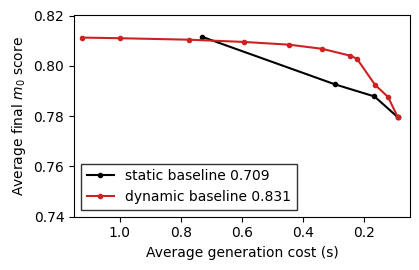

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2.5))
plt.plot(
	[x[0] for x in BASELINE_STATIC],
	[x[1] for x in BASELINE_STATIC],
	marker=".",
	color="black",
	label=f"static baseline {auc(BASELINE_STATIC):.3f}",
)
plt.plot(
	[x[0] for x in BASELINE_DYNAMIC],
	[x[1] for x in BASELINE_DYNAMIC],
	marker=".",
	color="#c22",
	label=f"dynamic baseline {auc(BASELINE_DYNAMIC):.3f}",
)
plt.gca().invert_xaxis()
plt.legend(fancybox=False, edgecolor="black")
plt.ylabel("Average final $m_0$ score")
plt.xlabel("Average generation cost (s)")

plt.ylim(0.74, 0.82)
plt.xlim(COST_MAX, COST_MIN)

plt.tight_layout(pad=0)
plt.savefig("../figures/results_baselines_skintle.pdf")
plt.show()